#### Imports

In [1]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np

# OCR with Adobe Acrobat and extraction with fitz

In [2]:
from __future__ import print_function
from itertools import groupby
import fitz
import matplotlib.pyplot as plt

- Functions for reading text from PDF

In [347]:
def find_edges(x0s):
    '''
    Find the coordinates of boxes that seperates the columns in the PDF file.
    '''
    # only one row of data (p86, p143)
    if max(x0s) < 200: 
        return (None, None) 
    
    # 2 rows of data (p146, p218)
    # the one before zero and the one after zero has a difference greater than 20, 
    if max(x0s) < 400: 
        counts, xedges, _ = plt.hist(x0s, bins = 40)
        i = 8
        while i < 30:
            if (counts[i] == 0) and (counts[i + 1] -  counts[i - 1] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                return (xedges[i], None)
            i += 1
        if i == 30:
            i = 8
            while i < 30:
                if (counts[i + 1] -  counts[i] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                    return (xedges[i], None)
                i += 1
        if i == 30:
            i = 8
            while i < 30:
                if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 160) and (xedges[i] < 220):
                    return (xedges[i], None)
                i += 1
    # 3 rows of data
    counts, xedges, _ = plt.hist(x0s, bins = 100)
    # line between col 1 & 2            
    i = 20
    while i < 45:
        if (counts[i] == 0) and (max(counts[i + 1], counts[i + 2]) - counts[i - 1] > 20) and (xedges[i] < 220):
            xcol1 = xedges[i]
            break
        i += 1
    if i == 45:
        i = 20
        while i < 45:
            if (max(counts[i], counts[i + 1]) - counts[i - 1] > 20) and (xedges[i] > 160) and (xedges[i] < 220):
                xcol1 = xedges[i]
                break
            i += 1
    if i == 45:
        i = 20
        while i < 45:
            if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 160) and (xedges[i] < 220):
                xcol1 = xedges[i + 1]
                break
            i += 1
            
    # line between col 2 & 3
    while i < 80:
        if (counts[i] == 0) and (max(counts[i + 1], counts[i + 2]) - counts[i - 1] > 20) and (xedges[i] > 330) and (xedges[i] < 390):
            xcol2 = xedges[i]
            break
        i += 1
    if i == 80:
        i = 50
        while i < 80:
            if (max(counts[i], counts[i + 1]) - counts[i - 1] > 20) and (xedges[i] > 330) and (xedges[i] < 390):
                xcol2 = xedges[i]
                break
            i += 1
    if i == 80:
        i = 50
        while i < 80:
            if (counts[i] == 0) and (counts[i + 1] == 0) and (xedges[i] > 330) and (xedges[i] < 390):
                xcol2 = xedges[i]
                break
            i += 1
    return (xcol1, xcol2)

In [398]:
def get_words_in_box(page):
    '''
    Extract words from each column of the PDF.
    '''
    x, y = page.MediaBox[2:] #size of page
    words = page.getText("words") #each word with extracted coordinate\
    #cut off top word if exist
    y0s = [word[1] for word in words]
    if sum(y0 < (min(y0s)+10) for y0 in y0s) < 3:
        words = [word for word in words if word[1] > (min(y0s)+10)]
    #cut off bottom
    words = [word for word in words if word[1] < (max(y0s)-10)]
    #find col 1 and 2
    x0s = [word[0] for word in words]
    xcol1, xcol2 = find_edges(x0s)
    page_txt = []
    if xcol1 == None:
        page_txt.append(words)
        return page_txt
    if xcol2 == None:
        page_txt.append([word for word in words if word[0] < xcol1])
        page_txt.append([word for word in words if word[0] > xcol1])
        return page_txt
    page_txt.append([word for word in words if word[0] < xcol1])
    page_txt.append([word for word in words if ((word[0] > xcol1) and (word[0] < xcol2))])
    page_txt.append([word for word in words if word[0] > xcol2])
    return page_txt

- Extract text

In [57]:
#open PDF which has gone through Adobe Acrobat OCR
doc = fitz.open("directory_1998_OCR.pdf")
len(doc)

568

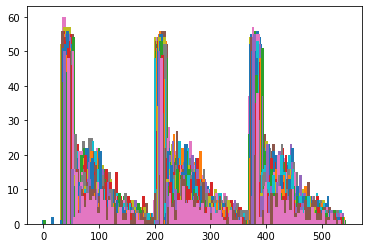

In [350]:
#get data
data = []
for pagen in range(12, 562):
    data.append(get_words_in_box(doc[pagen-1]))

# Write data into csv

- Split data into lines

In [356]:
abbr_keys = ["TX", "ML", "PV", "OS", "DT",\
             "OD", "OR", "IO", "ID", "IR", "RD", "RR",\
             "AD", "DD", "HV", "PW",\
             "SS", "GH", "PH", "OH", "TC", "HH", "CM", "CH", \
             "CO", "SG", "SC", "CJ",\
             "MC", "MD", "FG", "PI"]

In [357]:
def col_text_to_rows(col_text):
    '''
    Splits text into rows
    '''
    col_text_by_row = []
    temp = []
    init_y = col_text[0][1] #y0
    i = 0
    while i < len(col_text):
        if (col_text[i][1] < init_y + 3) and (col_text[i][1] > init_y - 3):
            temp.append(col_text[i][4])
        else:
            col_text_by_row.append(temp)
            temp = [col_text[i][4]]
            init_y = int(col_text[i][1])
        i += 1
    col_text_by_row.append(temp)
    return col_text_by_row

#runs the function on all data
def all_text_to_rows(data):
    all_text = []
    for page_text in data:
        page_text_by_row = []
        for col_text in page_text:
            page_text_by_row.append(col_text_to_rows(col_text))
        all_text.append(page_text_by_row)
    return all_text

In [358]:
#collect all text by page, column and line
all_text = all_text_to_rows(data)

- Writing text to .csv

In [593]:
def clean_key(key):
    return key.replace('Y', 'V').replace('1', 'I').replace('l', 'I').replace('0', 'O').replace('OT', 'DT').replace('OT', 'DT')

def is_keys(line):
    '''
    Check if the line (list of list) is a list of keys
    exp. ['TX', 'OT/', 'RD', 'RR/', 'SS']
    '''
    if clean_key(line[0][:2]) in abbr_keys:
        if len(line) == 1:
            if len(line[0]) == 2 or len(line[0]) == 3:
                return True
            test = line[0].replace('/', '')
            if clean_key(test[2:4]) in abbr_keys:
                return True
            else:
                return False
        elif clean_key(line[1][:2]) in abbr_keys:
            return True
    return False

def is_citystatezip(line):
    '''
    Check if the line contains city, state, zip info
    '''
    if len(line) < 3:
        return False
    #35294-0018 or 35294
    if (len(line[-1]) == 5 or len(line[-1]) == 10) and line[-1].replace('I', '1').replace('l', '1').replace('J', '1').replace('O', '0').replace('-', '')\
    .isnumeric()\
    and (len(line[-2]) == 2) and line[-2].isupper():
        return True
    #3540 I
    elif ''.join(line[-2:]).replace('I', '1').replace('l', '1').replace('O', '0').replace('-', '').replace('J', '1').isnumeric()\
    and (len(line[-3]) == 2) and line[-3].isupper():
        return True
    elif ''.join(line[-3:]).replace('I', '1').replace('l', '1').replace('O', '0').replace('-', '').replace('J', '1').isnumeric()\
    and (len(line[-4]) == 2) and line[-4].isupper():
        return True
    return False

address_indicators = ['Box', 'P.0.Box', 'Road', 'Highway', 'Route', 'Building', 'Street', 'Avenue', 'Suite', 'Drive', 'Boulevard']
name_indicators = ['Clinic']

def is_address(line):
    if any(x in line for x in name_indicators):
        return False
    if line[0].replace('-', '').isnumeric() or any(x in line for x in address_indicators):
        return True
    return False

def is_contact(line):
    #['(650)368-6355']
    #['Hotlines:']
    line = ''.join(line)
    if line[:3] == 'Hot':
        return True
    if line[0] == '(' and line[1:4].replace('I', '1').replace('O', '0').replace('l', '1').replace('J', '1').isnumeric():
        return True
    return False


def clean_citystatezip(line):
    #['Pasadena,', 'CA', '9', 'I', 'JO', '1-1804']
    #['Prescott,', 'AZ', '8630', 'l']
    #['Phoenix,', 'AZ', '850', 'I', '5']
    if ''.join(line[-3:]).replace('I', '1').replace('l', '1').replace('J', '1').replace('O', '0').replace('-', '').isnumeric():
        i = -3
    elif ''.join(line[-2:]).replace('I', '1').replace('l', '1').replace('J', '1').replace('O', '0').replace('-', '').isnumeric():
        i = -2
    else:
        i = -1
    zipc = ''.join(line[i:]).replace('I', '1').replace('O', '0').replace('l', '1').replace('J', '1')
    state = line[i - 1]
    city = ' '.join(line[0:i - 1])[:-1]
    return [city, state, zipc]

In [609]:
#['Pasadena,', 'CA', '9', 'I', 'JO', '1-1804']
#['Prescott,', 'AZ', '8630', 'l']
#['Phoenix,', 'AZ', '850', 'I', '5']

def is_citystatezip(line):
    '''
    Check if the line contains city, state, zip info
    '''
    if len(line) < 3:
        return False
    i = 0
    while i < len(line):
        if len(line[i]) == 2 and line[i].isupper():
            break
        i += 1
    if i == 0 or i == len(line):
        return False
    if ''.join(line[i + 1:]).replace('I', '1').replace('l', '1').replace('J', '1').replace('O', '0').replace('-', '').isnumeric():
        return True
    return False

def clean_citystatezip(line):
    i = 0
    while i < len(line):
        if len(line[i]) == 2 and line[i].isupper():
            break
        i += 1
    state = line[i]
    zipc = ''.join(line[i + 1:]).replace('I', '1').replace('O', '0').replace('l', '1').replace('J', '1')
    city = ' '.join(line[0:i])[:-1]
    return [city, state, zipc]

In [578]:
def split_col_data(col_text):
    '''
    Split column data into list of MOUD facilities.
    '''
    col_text_splitted = []
    temp = []
    i = 0
    while i < len(col_text) - 1:
        
        if re.search('[a-zA-Z0-9]', ''.join(col_text[i])): ##
            
            if is_keys(col_text[i]) and (not is_keys(col_text[i+1])):
                temp.append(col_text[i])
                col_text_splitted.append(temp)
                temp = []
            elif is_keys(col_text[i]) and (is_keys(col_text[i+1])):
                temp.append(col_text[i])
            else:
                if not ''.join(col_text[i]).isupper(): #not the capitalized city name which should be ignored
                    temp.append(col_text[i])
                
        i += 1
    temp.append(col_text[-1])
    col_text_splitted.append(temp)
    return col_text_splitted

In [612]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        data_holder = []
        i = 0 #indicator of next line
        #name1
        data_holder.append(' '.join(facil[0])) 
        i += 1
        #name2
        if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
            data_holder.append(' '.join(facil[i])) 
            i += 1
        else:
            data_holder.append('') 
        #name3
        if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
            data_holder.append(' '.join(facil[i])) 
            i += 1
        else:
            data_holder.append('')         
        #address1
        if is_address(facil[i]):
            data_holder.append(' '.join(facil[i])) 
            i += 1
        else:
            data_holder.append('')
        #address2
        if not is_citystatezip(facil[i]) and not is_contact(facil[i]) and not (is_keys(facil[i])): 
            data_holder.append(' '.join(facil[i])) 
            i += 1
        else:
            data_holder.append('')
        #city, state, zip
        data_holder += clean_citystatezip(facil[i])
        i += 1
        #contact
        if is_contact(facil[i]):
            data_holder.append(''.join(facil[i]))
            i += 1
            while i < len(facil):
                if is_contact(facil[i]):
                    data_holder[-1] += ' ' + ''.join(facil[i])
                    i += 1
                else:
                    break
        else:
            data_holder.append('')
        #keys
        data_holder.append('')
        for keys in facil[i:]:
            for key in keys:
                if len(key) == 2:
                    data_holder[-1] += clean_key(key) + '/'
                elif len(key) == 3:
                    data_holder[-1] += clean_key(key[:2]) + '/'
                else:
                    for key in key.split('/'):
                        if len(key) == 2:
                            data_holder[-1] += clean_key(key) + '/'
                        else:
                            data_holder[-1] += '/'.join([clean_key(key[i:i+2]) for i in range(0, len(key), 2)])
        data_holders.append(data_holder)
        print(".", end = '') #for each MOUD
    return data_holders

In [613]:
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", "Address1", "Address2", "City", "State", "ZIP_Code", "Contact", "Keys"])

In [614]:
filename = "1998.csv"
pagen = 12

for page in all_text:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        col_text_splitted = split_col_data(col)
        page_data_holders += clean_col_data(col_text_splitted)
        print(" Finished Col ", end = '')
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1
    print('')

Page: 12....... Finished Col ....... Finished Col ...... Finished Col 
Page: 13...... Finished Col ...... Finished Col ....... Finished Col 
Page: 14........ Finished Col ...... Finished Col ...... Finished Col 
Page: 15........ Finished Col ....... Finished Col ...... Finished Col 
Page: 16....... Finished Col ........ Finished Col ...... Finished Col 
Page: 17....... Finished Col ....... Finished Col .. Finished Col 
Page: 18...... Finished Col ....... Finished Col ....... Finished Col 
Page: 19....... Finished Col ........ Finished Col ....... Finished Col 
Page: 20....... Finished Col ......... Finished Col ........ Finished Col 
Page: 21........ Finished Col ....... Finished Col ....... Finished Col 
Page: 22....... Finished Col ...... Finished Col ....... Finished Col 
Page: 23........ Finished Col ........ Finished Col ........ Finished Col 
Page: 24...... Finished Col ...... Finished Col ....... Finished Col 
Page: 25....... Finished Col ........ Finished Col ........ Finished 

IndexError: list index out of range

In [615]:
pagen = 80
col = 2
MOUD = 3
#all_text[pagen - 12][col - 1]
split_col_data(all_text[pagen - 12][col - 1])[MOUD - 1]

[['Ventura', 'Recovery', 'Center'],
 ['Community', 'Recovery', 'Center'],
 ['166', 'Siesta', 'Avenue'],
 ['Thousand', 'Oaks,', 'CA', '9', 'I', '360', '.'],
 ['(805)499-8383'],
 ['Hotlines:'],
 ['(800)247-6111'],
 ['(805)499-8383'],
 ['TX', 'PY', 'OS/', 'RR/', 'DD/', 'SS', 'TC']]

- Rewrite data in problem pages

In [585]:
# pagen = 23
# col = 2
# all_text[pagen - 12][col - 1][5] = ['TX', 'ML', 'PV', 'OS', 'DT/', 'OD', 'OR/', 'DD', 'HY', 'PW/']

# pagen = 38
# col = 1
# all_text[pagen - 12][col - 1][28] = ['Eureka,', 'CA', '95503']

# pagen = 43
# col = 2
# all_text[pagen - 12][col - 1][7] = ['83844', 'Hopi', 'A', 'venue']
# all_text[pagen - 12][col - 1][7] = ['Indio,', 'CA', '92201']
# all_text[pagen - 12][col - 1][9] = ['(760)347-9442']

# pagen = 45
# col = 3
# all_text[pagen - 12][col - 1][4] = ['Long', 'Beach,', 'CA', '90813']

# pagen = 75
# col = 3
# all_text[pagen - 12][col - 1][3] = ['Santa', 'Cruz,', 'CA', '95060']

#pagen = 79
#col = 1

# Clean final data
- Replace "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"